# Plot full North American DTA tree with baltic

February 2, 2024

In [3]:
import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import json
import imp
import baltic as bt

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import numpy as np
import pandas as pd
#from scipy.special import binom

In [4]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [22]:
from datetime import date

today_date = str(date.today())
print(today_date)

2024-02-12


In [10]:

# This is for the orders, flyways, etc... 
tree_path='../Louise-analyses-h5nx-north-america-outbreak/Lambos-BEAST-analyses/order_equal_northamerica_h5nx.MCC.tree'

# this is for the domestic/wild analysis
#tree_path = 'domwild_meta_louise_20240202.MCC.tree'

In [11]:
tree=bt.loadNexus(tree_path)

In [12]:
metadata_translations = {
    "Three": "wild_migratory",
    "Two": "wild_partially_migratory",
    "One": "wild_sedentary",
    "domestic":"domestic",
    "nonhuman-mammal":"nonhuman_mammal"
}

In [13]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [14]:
def return_height_most_recent_tip(tree):
    all_heights = []
    
    for k in tree.Objects: 
        if k.branchType == "leaf":
            height = k.traits["height"]
            all_heights.append(height)
            
    height_youngest_tip = min(all_heights)
    return(height_youngest_tip)

In [15]:
def return_date_most_recent_tip(tree, height_youngest_tip):
    
    for k in tree.Objects: 
        if k.branchType == "leaf":
            height = k.traits["height"]
            if height == height_youngest_tip:
                date_string = k.name.split("|")[2]
                date_format = '%Y-%m-%d'

                date_obj = dt.strptime(date_string, date_format)
                decimal_date = toYearFraction(date_obj)
                
                return(decimal_date)

In [16]:
height_youngest_tip = return_height_most_recent_tip(tree)
age_youngest_tip = return_date_most_recent_tip(tree, height_youngest_tip)
print(age_youngest_tip)

2023.608105022831


In [17]:
def return_counts_of_traits_in_tree(tree,traitName):
    trait_counts = {}

    for k in tree.Objects: 
        if k.branchType == "leaf":
            trait_type = k.traits[traitName]
            if trait_type not in trait_counts: 
                trait_counts[trait_type] = 1
            else: 
                trait_counts[trait_type] += 1

    return(trait_counts)

In [ ]:
domwild_counts = return_counts_of_traits_in_tree(tree,"domwild")
print(domwild_counts)

In [18]:
migration_counts = return_counts_of_traits_in_tree(tree, "Migration")
order_counts = return_counts_of_traits_in_tree(tree, "order_condensed")

print(migration_counts)
print(order_counts)

{'domestic': 105, 'nonhuman-mammal': 100, 'One': 107, 'Three': 190, 'Two': 153}
{'galliformes': 100, 'nonhuman-mammal': 100, 'strigiformes': 98, 'accipitriformes': 100, 'passeriformes': 57, 'charadriiformes': 100, 'anseriformes': 100}


In [23]:
# try instead, clustering into regions and plotting it that way; we could do: west, 2 midwests, 2 souths, northeast
colors = {"wild_partially_migratory":"#93B2D2",
          "wild_sedentary": "#D1BA56",#"#D1BA56" yellow color,
          "wild_migratory":"#2664A5",
          "nonhuman_mammal":"#B2313D",
          "domestic":"#5CA7A4", 
         
         "anseriformes":"#2664A5",
         "charadriiformes":"#93B2D2",
         "galliformes":"#5CA7A4",
         "strigiformes":"#EEA160", 
          "passeriformes":"#D1BA56",
         "accipitriformes":"#50357A",
          "nonhuman-mammal":"#B2313D", 
          
          "wild":"#2664A5", 
          "nonhuman_mammal":"#B2313D",
          "backyard_bird":"#D1BA56"
         }


uncertainty_color:"#B9B9B9"

color_order_migration = ["wild_migratory","wild_partially_migratory","wild_sedentary",
               "domestic","nonhuman_mammal"]

color_order_orders = ["anseriformes","charadriiformes","accipitriformes","passeriformes","strigiformes",
                      "galliformes","nonhuman-mammal"]

color_order_domwild = ["wild","domestic","nonhuman-mammal"]
color_order_domwild_byb = ["wild","domestic","backyard_bird","nonhuman-mammal"]

In [33]:
def plot_tree_colored_nodes(tree, filename, traitName, color_list, metadata_translations):
    
    fig,ax = plt.subplots(figsize=(10,8),facecolor='w')

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    dates_ls = []
    for i in range(2021,2025,1):
        dates_ls.append(i)  
    #dates = dates_ls[::2]
    #[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in dates]

    # set date labels to be every 4
    # date_labels = []
    # for d in dates_ls[::4]:
    #     date_labels.append(str(d))
    #     if d < 2018:
    #         date_labels.append("")

    branchWidth=1.5 ## default branch width
    tipSize = 15

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y 

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            if traitName == "Migration":
                traitValue = metadata_translations[k.traits[traitName]]
            else: 
                traitValue = k.traits[traitName]
            
            traitProb = k.traits[traitName+".prob"]
            base_color=colors[traitValue]
            color_ramp = clr.LinearSegmentedColormap.from_list('custom ', ["#B9B9B9",base_color], N=256)
            c = color_ramp(traitProb)
            s=tipSize

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            number_children = len(k.leaves)
            node_branchwidth = branchWidth + number_children*0.0025
            
            if traitName == "Migration":
                traitValue = metadata_translations[k.traits[traitName]]
            else: 
                traitValue = k.traits[traitName]

            traitProb = k.traits[traitName+".prob"]
            base_color=colors[traitValue]
            color_ramp = clr.LinearSegmentedColormap.from_list('custom ', ["#B9B9B9", base_color], N=256)
            c = color_ramp(traitProb)
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]

        ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)

        # add in a legend
        han_list = []

        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    for key in color_list:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title().replace("nonhuman_mammal","Nonhuman Mammal").replace("Nonhuman-Mammal","Nonhuman\nMammal").replace("bird","Bird").replace("Partially Migratory","Partially\nMigratory"), markersize = 10, markeredgewidth=2)
        han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-5,tree.ySpan+5)
    ax.set_xlim(2020.5,2024)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=24,size=5, width=2,color='grey')
    ax.set_xticks(dates_ls)
    ax.set_xticklabels(dates_ls)   # set date labels every 4
    ax.set_yticklabels([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.02, 0.02], loc=3,prop={'size': 22}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)
    plt.savefig(filename)

    plt.show()

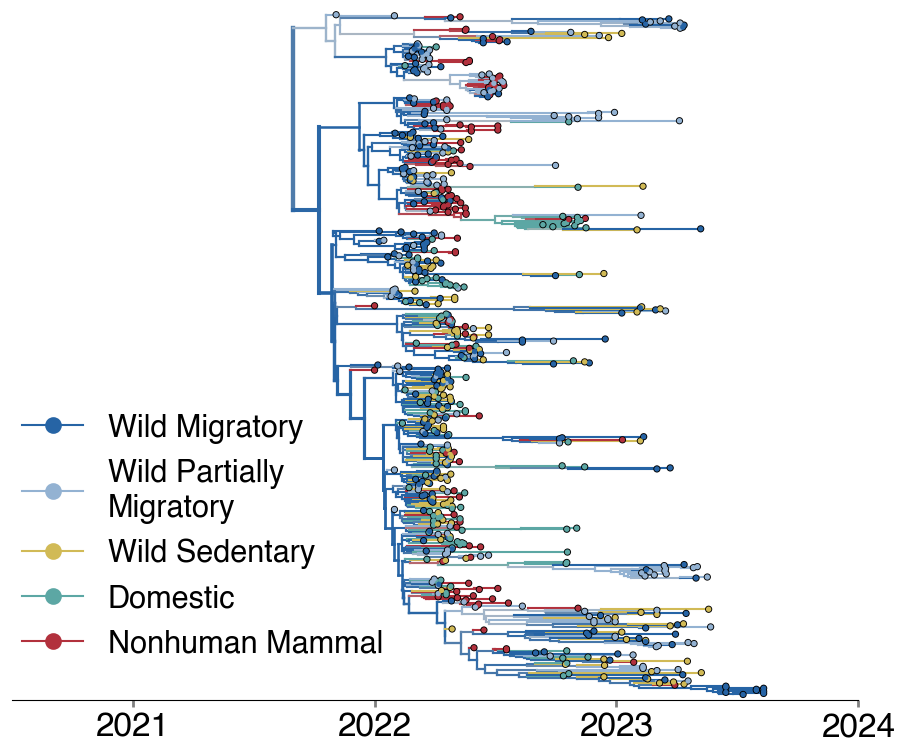

In [36]:
# set output filename
traitName = "Migration"
color_list = color_order_migration
filename = "h5nx-dta-"+traitName+today_date+".pdf"

plot_tree_colored_nodes(tree, filename, traitName, color_list, metadata_translations)

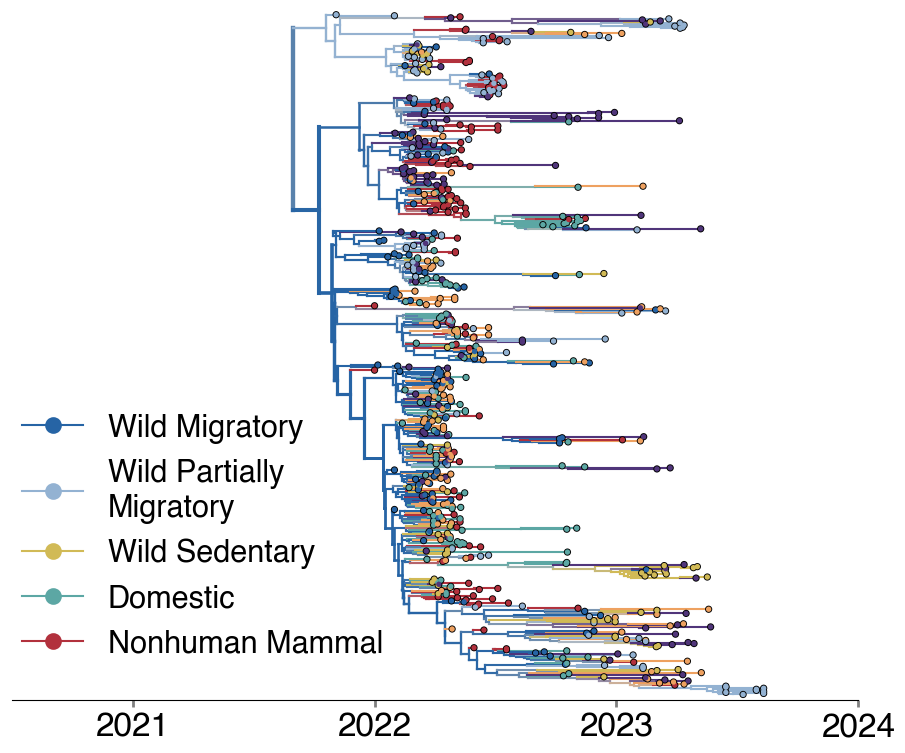

In [38]:
# set output filename
traitName = "order_condensed"
color_list = color_order_migration
filename = "h5nx-dta-"+traitName+today_date+".pdf"

plot_tree_colored_nodes(tree, filename, traitName, color_list, metadata_translations)

## Plot with tips colored by whether backyard bird, with backbone black

In [40]:
def plot_tree_grey_nodes(tree, filename, traitName, color_list, metadata_translations, black_color):
    
    fig,ax = plt.subplots(figsize=(10,8),facecolor='w')

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    dates_ls = []
    for i in range(2021,2025,1):
        dates_ls.append(i)  
    #dates = dates_ls[::2]
    #[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in dates]

    # set date labels to be every 4
    # date_labels = []
    # for d in dates_ls[::4]:
    #     date_labels.append(str(d))
    #     if d < 2018:
    #         date_labels.append("")

    branchWidth=1.5 ## default branch width
    tipSize = 15

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y 

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            if traitName == "Migration":
                traitValue = metadata_translations[k.traits[traitName]]
            else: 
                traitValue = k.traits[traitName]
            
            traitProb = k.traits[traitName+".prob"]
            base_color=colors[traitValue]
            color_ramp = clr.LinearSegmentedColormap.from_list('custom ', ["#B9B9B9",base_color], N=256)
            c = color_ramp(traitProb)
            s=tipSize

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            number_children = len(k.leaves)
            node_branchwidth = branchWidth + number_children*0.0025
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=black_color,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        
        ax.plot([xp,x],[y,y],lw=node_branchwidth,color=black_color,ls='-',zorder=9)

        # add in a legend
        han_list = []

        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    for key in color_list:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title().replace("nonhuman_mammal","Nonhuman Mammal").replace("Nonhuman-Mammal","Nonhuman\nMammal").replace("bird","Bird").replace("Partially Migratory","Partially\nMigratory"), markersize = 10, markeredgewidth=2)
        han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-5,tree.ySpan+5)
    ax.set_xlim(2020.5,2024)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=24,size=5, width=2,color='grey')
    ax.set_xticks(dates_ls)
    ax.set_xticklabels(dates_ls)   # set date labels every 4
    ax.set_yticklabels([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.02, 0.02], loc=3,prop={'size': 22}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)
    plt.savefig(filename)

    plt.show()

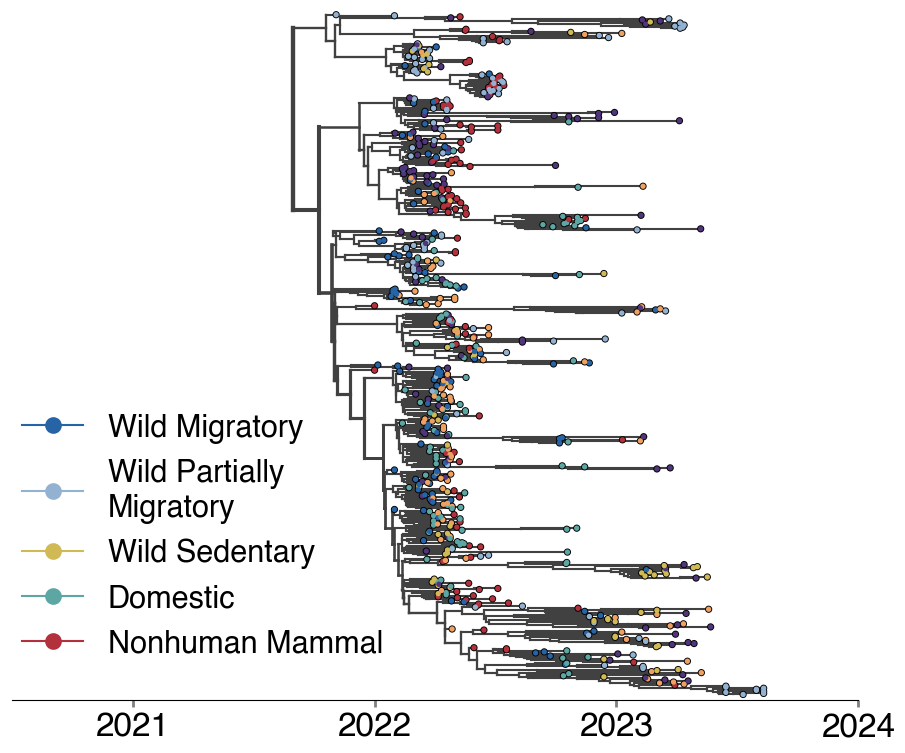

In [41]:
traitName = "order_condensed"
filename_domwild_byb = "h5nx-dta-"+traitName+today_date+".pdf"
black_color = "#414141"
plot_tree_grey_nodes(tree, filename, traitName, color_list, metadata_translations, black_color)

# Plot node probabilities over time

In [136]:
most_recent_date = age_youngest_tip

In [137]:
def return_node_probs_by_date(tree):
    
    node_probs = {}
    
    for k in tree.Objects: 
        if k.branchType == "node":
            host = k.traits["order_condensed"]
            host_prob = k.traits["order_condensed.prob"]
            height = k.traits["height"]
            date = most_recent_date - height
            node_probs[k] = {"host":host, "host_prob":host_prob,"date":date}
            
    return(node_probs)

In [138]:
node_probs = return_node_probs_by_date(tree)

In [141]:
df = pd.DataFrame.from_dict(node_probs, orient="index")
df.head()

,host,host_prob,date
<baltic.node object at 0x1139c1540>,anseriformes,0.650483,2021.663424
<baltic.node object at 0x1139c2230>,anseriformes,0.973895,2021.770839
<baltic.node object at 0x1139c37f0>,anseriformes,1.000000,2021.824397
<baltic.node object at 0x107d6c0d0>,anseriformes,1.000000,2021.830929
<baltic.node object at 0x107e0bf10>,anseriformes,1.000000,2021.844124


In [148]:
anseriformes="#2664A5",
charadriiformes="#93B2D2",
galliformes="#5CA7A4",
strigiformes="#EEA160", 
passeriformes="#D1BA56",
accipitriformes="#50357A",
nonhuman_mammal="#B2313D"

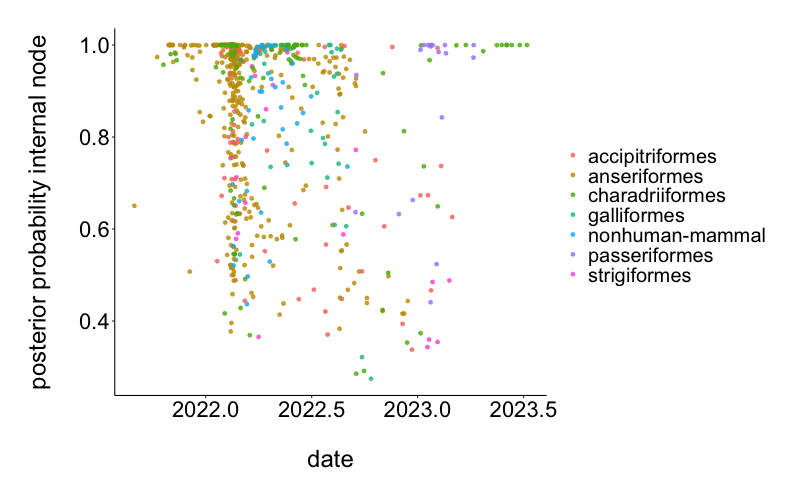

In [153]:
%%R -w 800 -h 500 -u px -i df  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("internal-node-probabilities-",".pdf", sep="")

p <- ggplot(data=df, aes(x=date, y=host_prob, color=host, fill=host)) +
    geom_point(alpha=0.8)+
    labs(x="\ndate",y="posterior probability internal node\n")+
    #labs(x=paste("\nmigrations per lineage per year\n(",mig_direction,")",sep=""),y="density\n")+
#      scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#      scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,1,0.2), limits=c(0.8,1))+
#     scale_x_continuous(breaks=seq(0,3,1), limits=c(0,3))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

In [154]:
print(len(df))
df_high_prob = df[df['host_prob'] >= 0.9]
print(len(df_high_prob))
df_high_prob.head()

654
379


,host,host_prob,date
<baltic.node object at 0x1139c2230>,anseriformes,0.973895,2021.770839
<baltic.node object at 0x1139c37f0>,anseriformes,1.000000,2021.824397
<baltic.node object at 0x107d6c0d0>,anseriformes,1.000000,2021.830929
<baltic.node object at 0x107e0bf10>,anseriformes,1.000000,2021.844124
<baltic.node object at 0x107e0bee0>,anseriformes,0.995181,2021.897581


In [ ]:
         "anseriformes":"#2664A5",
         "charadriiformes":"#93B2D2",
         "galliformes":"#5CA7A4",
         "strigiformes":"#EEA160", 
          "passeriformes":"#D1BA56",
         "accipitriformes":"#50357A",
          "nonhuman-mammal":"#B2313D"

In [165]:
proportions_df = pd.DataFrame()

#for i in range(2020, 2024):

for i in np.arange(2021,2024,0.083):
    
    local_df = df_high_prob[(df_high_prob["date"] > i)&(df_high_prob["date"] < i+1)]
    total_internal_nodes = len(local_df)
    
    if total_internal_nodes != 0:
        count_anseriformes = len(local_df[local_df["host"]=="anseriformes"])
        count_galliformes = len(local_df[local_df["host"]=="galliformes"])
        count_charadriiformes = len(local_df[local_df["host"]=="charadriiformes"])
        count_strigiformes = len(local_df[local_df["host"]=="strigiformes"])
        count_passeriformes = len(local_df[local_df["host"]=="passeriformes"])
        count_accipitriformes = len(local_df[local_df["host"]=="accipitriformes"])
        count_nonhuman_mammal = len(local_df[local_df["host"]=="nonhuman-mammal"])

        prop_anseriformes = count_anseriformes/total_internal_nodes
        prop_galliformes = count_galliformes/total_internal_nodes
        prop_charadriiformes = count_charadriiformes/total_internal_nodes
        prop_strigiformes = count_strigiformes/total_internal_nodes
        prop_passeriformes = count_passeriformes/total_internal_nodes
        prop_accipitriformes = count_accipitriformes/total_internal_nodes
        prop_nonhuman_mammal = count_nonhuman_mammal/total_internal_nodes
    
    else: 
        prop_anseriformes = 0
        prop_galliformes = 0
        prop_charadriiformes = 0
        prop_strigiformes = 0
        prop_passeriformes = 0
        prop_accipitriformes = 0
        prop_nonhuman_mammal = 0

    
    df2 = pd.DataFrame.from_dict({"year": i, "prop_anseriformes":[prop_anseriformes], 
                                  "prop_galliformes":[prop_galliformes],
                                  "prop_charadriiformes":[prop_charadriiformes],
                                  "prop_strigiformes":[prop_strigiformes],
                                  "prop_passeriformes":[prop_passeriformes],
                                  "prop_accipitriformes":[prop_accipitriformes],
                                  "prop_nonhuman_mammal":[prop_nonhuman_mammal],
                                  "total_internal_nodes":total_internal_nodes})
    proportions_df = pd.concat([proportions_df, df2])
    
proportions_df

,year,prop_anseriformes,prop_galliformes,prop_charadriiformes,prop_strigiformes,prop_passeriformes,prop_accipitriformes,prop_nonhuman_mammal,total_internal_nodes
0,2021.000,0.857143,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,28
0,2021.083,0.807692,0.000000,0.173077,0.000000,0.000000,0.019231,0.000000,52
0,2021.166,0.797170,0.004717,0.155660,0.000000,0.000000,0.042453,0.000000,212
0,2021.249,0.758197,0.008197,0.151639,0.016393,0.004098,0.036885,0.024590,244
0,2021.332,0.702899,0.032609,0.141304,0.028986,0.003623,0.032609,0.057971,276
0,2021.415,0.663366,0.029703,0.165017,0.029703,0.003300,0.029703,0.079208,303
0,2021.498,0.637500,0.028125,0.193750,0.028125,0.003125,0.034375,0.075000,320
0,2021.581,0.643293,0.027439,0.189024,0.027439,0.003049,0.036585,0.073171,328
0,2021.664,0.640805,0.045977,0.178161,0.025862,0.002874,0.037356,0.068966,348
0,2021.747,0.643059,0.045326,0.175637,0.025496,0.005666,0.036827,0.067989,353


In [168]:
proportions_df = pd.melt(proportions_df, id_vars=['year', 'total_internal_nodes'])
proportions_df

,year,total_internal_nodes,variable,value
0,2021.000,28,prop_anseriformes,0.857143
1,2021.083,52,prop_anseriformes,0.807692
2,2021.166,212,prop_anseriformes,0.797170
3,2021.249,244,prop_anseriformes,0.758197
4,2021.332,276,prop_anseriformes,0.702899
...,...,...,...,...
254,2023.656,0,prop_nonhuman_mammal,0.000000
255,2023.739,0,prop_nonhuman_mammal,0.000000
256,2023.822,0,prop_nonhuman_mammal,0.000000
257,2023.905,0,prop_nonhuman_mammal,0.000000


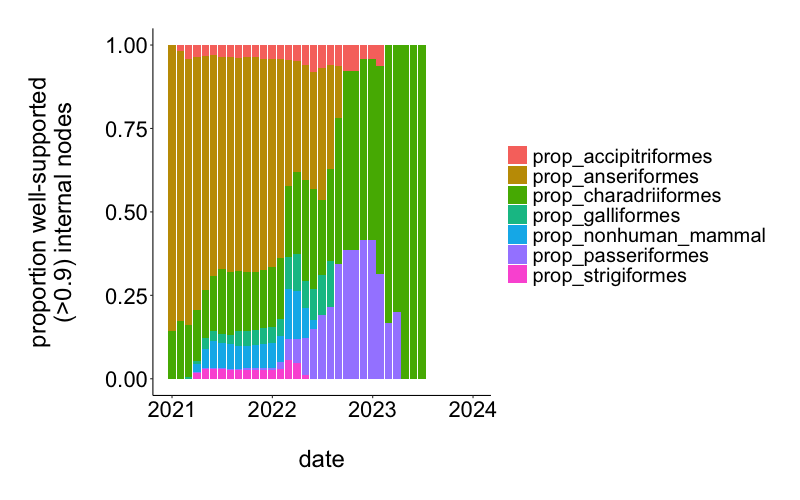

In [171]:
%%R -w 800 -h 500 -u px -i proportions_df # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("internal-node-probabilities-all-over-0.9-histogram.pdf", sep="")

p <- ggplot(data=proportions_df, aes(x=year, y=value, fill=variable)) +
    geom_bar(stat="identity")+
    labs(x="\ndate",y="proportion well-supported\n(>0.9) internal nodes\n")+
    #labs(x=paste("\nmigrations per lineage per year\n(",mig_direction,")",sep=""),y="density\n")+
     #scale_color_manual(values=c(prop_domestic=domestic_color,prop_wild=wild_color,prop_human=human_color), labels=c(prop_domestic="domestic",prop_wild="wild",prop_human="human"))+
#     scale_fill_manual(values=c(prop_domestic=domestic_color,prop_wild=wild_color,prop_human=human_color), labels=c(prop_domestic="domestic",prop_wild="wild",prop_human="human"))+
#     scale_y_continuous(breaks=seq(0,1,0.2), limits=c(0.8,1))+
#    scale_x_continuous(breaks=seq(2021,2023.5,0.083), limits=c(2021,2023.241))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "figures", dpi = 300)
p